In [4]:
import pandas as pd
from rdkit import Chem
# from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from chembl_webresource_client.new_client import new_client
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import torch
from tape import ProteinBertModel, TAPETokenizer
from tqdm import tqdm
# Load MOSES SMILES file
# df = pd.read_csv("../moses/data/train.smi", names=["smiles"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:

tcomp_api    = new_client.target_component


/Users/chusanarompo/miniforge3/envs/targetganPlay/lib/python3.10/site-packages/chembl_webresource_client/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('chembl_webresource_client').version


device(type='cuda')

False


AssertionError: Torch not compiled with CUDA enabled

In [3]:
df_drugsmiles = pd.read_csv("/Users/chusanarompo/DEV/MASTER/TargetGAN_play/data/CPI/smiles.smi", names=["smiles"])
print(df_drugsmiles.head())
print(df_drugsmiles.shape)

                                              smiles
0  [CH2]C1CC(n2ccc3c(-c4cc5cc(OC)ccc5[nH]4)ncnc32...
1  [CH2]C1CC(n2ccc3c(-c4cc5ccc(C)cc5[nH]4)ncnc32)...
2  [CH2]C1CC(n2ccc3c(-c4cc5ccccc5[nH]4)nc(C)nc32)...
3  NS(=O)(=O)OCC1CC(n2ccc3c(-c4cc5ccccc5[nH]4)ncn...
4  [CH2]C1CC(n2ccc3c(-c4cc5ccc(Cl)cc5[nH]4)ncnc32...
(551223, 1)


In [4]:
df_protein = pd.read_csv("/Users/chusanarompo/DEV/MASTER/TargetGAN_play/data/CPI/uniprot_ID.smi", names=["smiles"])
print(df_protein.head())
print(df_protein.shape)

   smiles
0  A0AVT1
1  A0AVT1
2  A0AVT1
3  A0AVT1
4  A0AVT1
(551223, 1)


In [14]:
df_all = pd.merge(df_drugsmiles,df_protein, left_index=True, right_index=True)
df_all = df_all.rename(columns={'smiles_x': 'drug_smiles', 'smiles_y': 'protein_id'})

df_all

,drug_smiles,protein_id
0,[CH2]C1CC(n2ccc3c(-c4cc5cc(OC)ccc5[nH]4)ncnc32...,A0AVT1
1,[CH2]C1CC(n2ccc3c(-c4cc5ccc(C)cc5[nH]4)ncnc32)...,A0AVT1
2,[CH2]C1CC(n2ccc3c(-c4cc5ccccc5[nH]4)nc(C)nc32)...,A0AVT1
3,NS(=O)(=O)OCC1CC(n2ccc3c(-c4cc5ccccc5[nH]4)ncn...,A0AVT1
4,[CH2]C1CC(n2ccc3c(-c4cc5ccc(Cl)cc5[nH]4)ncnc32...,A0AVT1
...,...,...
551218,N=C(N)Nc1ccc(CC(NC(=O)OCc2ccccc2)P(=O)(Oc2cccc...,Q9Y5K2
551219,N=C(N)NCCCC(NC(=O)OCc1ccccc1)P(=O)(Oc1ccccc1)O...,Q9Y5K2
551220,N=C(N)c1ccc(CCC(NC(=O)OCc2ccccc2)P(=O)(Oc2cccc...,Q9Y5K2
551221,N=C(N)Nc1ccc(C(NC(=O)OCc2ccccc2)P(=O)(Oc2ccccc...,Q9Y5K2


In [31]:
def fetch_sequence(accession_ID):
    rows = tcomp_api.filter(accession = accession_ID, organism='Homo sapiens').only(['organism','sequence'])  # accession is UniProt
    
    if len(rows) == 1:
        rows = rows[0]
    else: 
        print("SO THERE IS A CASE WHERE 1 ACCESSION is >1 protein sequence???")
        print(accession_ID)

    # print(f'AMINO SEQUENCE of Accession {accession_ID}: ', rows['sequence'])

    return rows

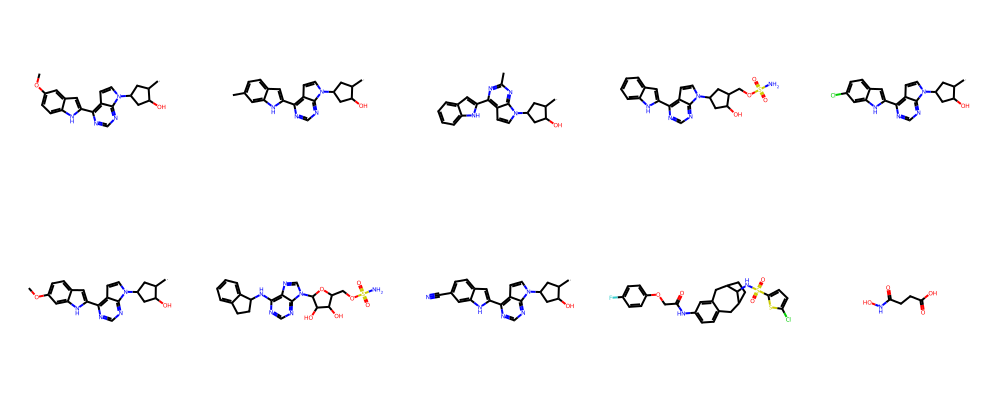

In [6]:
# Convert first few to molecules
mols = [Chem.MolFromSmiles(s) for s in df_drugsmiles["smiles"].head(10)]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
img
# img.save("sample_mols.png")

### Sample from their dataset

In [15]:
sampled = df_all.sample(frac=0.01, random_state=42)  # 
print(f"Sampled pairs: {len(sampled)}")

Sampled pairs: 5512


### Get protein seq

In [24]:
# Deduplicate to avoid repeated API calls
unique_proteins = sampled['protein_id'].unique()
unique_proteins

array(['P28845', 'P34972', 'P53350', 'P35372', 'P11511', 'P14416',
       'P33032', 'O00311', 'P00338', 'Q06418', 'Q9HC29', 'Q9NS75',
       'Q99705', 'P12931', 'Q9BY41', 'P29350', 'P10275', 'O96013',
       'P04150', 'O00329', 'P07477', 'P30556', 'Q07343', 'Q9UBF8',
       'P00734', 'P00746', 'P03956', 'P21397', 'P26572', 'Q96PD7',
       'Q07820', 'P67870', 'P56524', 'P56373', 'Q9Y5Y4', 'P06493',
       'P50281', 'Q969S8', 'P48048', 'Q99500', 'P25101', 'P48546',
       'P10827', 'Q9HBW0', 'Q92847', 'P20309', 'P00749', 'P25024',
       'Q15759', 'P41145', 'P09874', 'P05067', 'P08235', 'P18031',
       'Q9UKV0', 'P0DMS8', 'Q96LD8', 'P32245', 'P15907', 'P56817',
       'Q08499', 'P33981', 'P14555', 'P78536', 'P49768', 'P00918',
       'Q13946', 'P05129', 'P00915', 'P11309', 'P11413', 'O15379',
       'P41146', 'Q9UBL9', 'Q02127', 'P08913', 'P24941', 'P14867',
       'P20292', 'Q9HBH9', 'P28223', 'P05556', 'P45984', 'P11166',
       'Q99720', 'Q9UGN5', 'P25774', 'P51843', 'P17931', 'P228

In [29]:
protein_seqs = {}
for pid in tqdm(unique_proteins, desc="Fetching sequences"):
    seq = fetch_sequence(pid)
    protein_seqs[pid] = seq

# Append sequences back to the DataFrame
sampled['sequence'] = sampled['protein_id'].map(protein_seqs)

Fetching sequences:  50%|████▉     | 473/950 [09:29<10:02,  1.26s/it]

SO THERE IS A CASE WHERE 1 ACCESSION is >1 protein sequence???


Fetching sequences: 100%|██████████| 950/950 [19:20<00:00,  1.22s/it]


In [32]:
sampled

,drug_smiles,protein_id,sequence
242237,CN(C(C)(C)C(=O)NC1C2CC3CC1CC(C(N)=O)(C3)C2)S(=...,P28845,"{'organism': 'Homo sapiens', 'sequence': 'MAFM..."
275805,O=C(c1ccncn1)N1CCC(O)(c2ccccc2)C2CCCCC21,P34972,"{'organism': 'Homo sapiens', 'sequence': 'MEEC..."
378646,CCC1(F)CN(C2CCCC2)c2nc(Nc3ccc(C(=O)NC4CCN(C)CC...,P53350,"{'organism': 'Homo sapiens', 'sequence': 'MSAA..."
291446,O=C1N(CCCN2CCCC2)CN(c2ccccc2)C12CCN(C(c1ccccc1...,P35372,"{'organism': 'Homo sapiens', 'sequence': 'MDSS..."
140824,N#Cc1ccc(Cn2ccnc2)c2ccccc12,P11511,"{'organism': 'Homo sapiens', 'sequence': 'MVLE..."
...,...,...,...
353962,CS(=O)(=O)Nc1ccc(OC(=O)N2CCC(C(O)(c3ccccc3)c3c...,P49146,"{'organism': 'Homo sapiens', 'sequence': 'MGPI..."
282217,O=C(Nc1ccc(I)cc1)C(=O)Nc1ccc(NC(=O)C(c2ccccc2)...,P35236,"{'organism': 'Homo sapiens', 'sequence': 'MVQA..."
464372,NS(=O)(=O)c1cccc(-n2c(S)nc3ccc(I)cc3c2=O)c1,Q16790,"{'organism': 'Homo sapiens', 'sequence': 'MAPL..."
216729,CC(Nc1ccc(Cl)cc1)C(=O)Nc1nc2ccc3[nH]ncc3c2s1,P25098,"{'organism': 'Homo sapiens', 'sequence': 'MADL..."


In [ ]:
sampled['sequence_str'] = sampled['sequence'].apply(lambda x: x.get('sequence') if isinstance(x, dict) else None)
sampled


,drug_smiles,protein_id,sequence,sequence_str
242237,CN(C(C)(C)C(=O)NC1C2CC3CC1CC(C(N)=O)(C3)C2)S(=...,P28845,"{'organism': 'Homo sapiens', 'sequence': 'MAFM...",MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...
275805,O=C(c1ccncn1)N1CCC(O)(c2ccccc2)C2CCCCC21,P34972,"{'organism': 'Homo sapiens', 'sequence': 'MEEC...",MEECWVTEIANGSKDGLDSNPMKDYMILSGPQKTAVAVLCTLLGLL...
378646,CCC1(F)CN(C2CCCC2)c2nc(Nc3ccc(C(=O)NC4CCN(C)CC...,P53350,"{'organism': 'Homo sapiens', 'sequence': 'MSAA...",MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...
291446,O=C1N(CCCN2CCCC2)CN(c2ccccc2)C12CCN(C(c1ccccc1...,P35372,"{'organism': 'Homo sapiens', 'sequence': 'MDSS...",MDSSAAPTNASNCTDALAYSSCSPAPSPGSWVNLSHLDGNLSDPCG...
140824,N#Cc1ccc(Cn2ccnc2)c2ccccc12,P11511,"{'organism': 'Homo sapiens', 'sequence': 'MVLE...",MVLEMLNPIHYNITSIVPEAMPAATMPVLLLTGLFLLVWNYEGTSS...
...,...,...,...,...
353962,CS(=O)(=O)Nc1ccc(OC(=O)N2CCC(C(O)(c3ccccc3)c3c...,P49146,"{'organism': 'Homo sapiens', 'sequence': 'MGPI...",MGPIGAEADENQTVEEMKVEQYGPQTTPRGELVPDPEPELIDSTKL...
282217,O=C(Nc1ccc(I)cc1)C(=O)Nc1ccc(NC(=O)C(c2ccccc2)...,P35236,"{'organism': 'Homo sapiens', 'sequence': 'MVQA...",MVQAHGGRSRAQPLTLSLGAAMTQPPPEKTPAKKHVRLQERRGSNV...
464372,NS(=O)(=O)c1cccc(-n2c(S)nc3ccc(I)cc3c2=O)c1,Q16790,"{'organism': 'Homo sapiens', 'sequence': 'MAPL...",MAPLCPSPWLPLLIPAPAPGLTVQLLLSLLLLVPVHPQRLPRMQED...
216729,CC(Nc1ccc(Cl)cc1)C(=O)Nc1nc2ccc3[nH]ncc3c2s1,P25098,"{'organism': 'Homo sapiens', 'sequence': 'MADL...",MADLEAVLADVSYLMAMEKSKATPAARASKKILLPEPSIRSVMQKY...


In [45]:
sampled.isna().sum()

drug_smiles     0
protein_id      0
sequence        0
sequence_str    0
dtype: int64

In [49]:
sampled.describe()

,drug_smiles,protein_id,sequence,sequence_str
count,5508,5508,5508,5508
unique,5422,949,949,949
top,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,P00742,"{'organism': 'Homo sapiens', 'sequence': 'MGRP...",MGRPLHLVLLSASLAGLLLLGESLFIRREQANNILARVTRANSFLE...
freq,7,50,50,50


### Save sampled drug-sequence pair

In [50]:
sampled.to_csv('sampled_pairs_with_sequence_310825.csv', index=False)


### Load sampled drug-sequence pair

In [5]:
sampled = pd.read_csv('sampled_pairs_with_sequence_310825.csv')
sampled

,drug_smiles,protein_id,sequence,sequence_str
0,CN(C(C)(C)C(=O)NC1C2CC3CC1CC(C(N)=O)(C3)C2)S(=...,P28845,"{'organism': 'Homo sapiens', 'sequence': 'MAFM...",MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...
1,O=C(c1ccncn1)N1CCC(O)(c2ccccc2)C2CCCCC21,P34972,"{'organism': 'Homo sapiens', 'sequence': 'MEEC...",MEECWVTEIANGSKDGLDSNPMKDYMILSGPQKTAVAVLCTLLGLL...
2,CCC1(F)CN(C2CCCC2)c2nc(Nc3ccc(C(=O)NC4CCN(C)CC...,P53350,"{'organism': 'Homo sapiens', 'sequence': 'MSAA...",MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...
3,O=C1N(CCCN2CCCC2)CN(c2ccccc2)C12CCN(C(c1ccccc1...,P35372,"{'organism': 'Homo sapiens', 'sequence': 'MDSS...",MDSSAAPTNASNCTDALAYSSCSPAPSPGSWVNLSHLDGNLSDPCG...
4,N#Cc1ccc(Cn2ccnc2)c2ccccc12,P11511,"{'organism': 'Homo sapiens', 'sequence': 'MVLE...",MVLEMLNPIHYNITSIVPEAMPAATMPVLLLTGLFLLVWNYEGTSS...
...,...,...,...,...
5503,CS(=O)(=O)Nc1ccc(OC(=O)N2CCC(C(O)(c3ccccc3)c3c...,P49146,"{'organism': 'Homo sapiens', 'sequence': 'MGPI...",MGPIGAEADENQTVEEMKVEQYGPQTTPRGELVPDPEPELIDSTKL...
5504,O=C(Nc1ccc(I)cc1)C(=O)Nc1ccc(NC(=O)C(c2ccccc2)...,P35236,"{'organism': 'Homo sapiens', 'sequence': 'MVQA...",MVQAHGGRSRAQPLTLSLGAAMTQPPPEKTPAKKHVRLQERRGSNV...
5505,NS(=O)(=O)c1cccc(-n2c(S)nc3ccc(I)cc3c2=O)c1,Q16790,"{'organism': 'Homo sapiens', 'sequence': 'MAPL...",MAPLCPSPWLPLLIPAPAPGLTVQLLLSLLLLVPVHPQRLPRMQED...
5506,CC(Nc1ccc(Cl)cc1)C(=O)Nc1nc2ccc3[nH]ncc3c2s1,P25098,"{'organism': 'Homo sapiens', 'sequence': 'MADL...",MADLEAVLADVSYLMAMEKSKATPAARASKKILLPEPSIRSVMQKY...


### Init TAPE model to embed protein sequence

In [6]:
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model
model.eval()

ProteinBertModel(
  (embeddings): ProteinBertEmbeddings(
    (word_embeddings): Embedding(30, 768, padding_idx=0)
    (position_embeddings): Embedding(8192, 768)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ProteinBertEncoder(
    (layer): ModuleList(
      (0-11): 12 x ProteinBertLayer(
        (attention): ProteinBertAttention(
          (self): ProteinBertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ProteinBertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermed

In [7]:
print(torch.cuda.is_available())
model = model.to(device)
# tokenizer = tokenizer.to(device)

True


### Protein Sequence Embedding

In [10]:
embeddings = {}
seq_cache = {}

for pid, seq in zip(tqdm(sampled['protein_id']), sampled['sequence_str']):
    if seq not in seq_cache:
        ids = torch.tensor([tokenizer.encode(seq)]).to(device)
        with torch.no_grad():
            pooled = model(ids)[1].squeeze(0).cpu().numpy()
        seq_cache[seq] = pooled

    embeddings[pid] = seq_cache[seq]


100%|██████████| 5508/5508 [00:22<00:00, 240.28it/s]


### Drug smiles embedding to morgan fingerprint, 2048 bits

In [ ]:
fingerprints = {}
for smi in sampled['drug_smiles']:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        fingerprints[smi] = np.array(fp)

### Save npz of embedding [Protein] and fingerprints [Drug]

In [13]:
np.savez('protein_embeddings.npz', **embeddings)
np.savez('drug_fingerprints.npz', **fingerprints)

In [8]:
print(fingerprints)
print(embeddings)

NameError: name 'fingerprints' is not defined

### Activation pair DF

In [9]:
sampled

,drug_smiles,protein_id,sequence,sequence_str
0,CN(C(C)(C)C(=O)NC1C2CC3CC1CC(C(N)=O)(C3)C2)S(=...,P28845,"{'organism': 'Homo sapiens', 'sequence': 'MAFM...",MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...
1,O=C(c1ccncn1)N1CCC(O)(c2ccccc2)C2CCCCC21,P34972,"{'organism': 'Homo sapiens', 'sequence': 'MEEC...",MEECWVTEIANGSKDGLDSNPMKDYMILSGPQKTAVAVLCTLLGLL...
2,CCC1(F)CN(C2CCCC2)c2nc(Nc3ccc(C(=O)NC4CCN(C)CC...,P53350,"{'organism': 'Homo sapiens', 'sequence': 'MSAA...",MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...
3,O=C1N(CCCN2CCCC2)CN(c2ccccc2)C12CCN(C(c1ccccc1...,P35372,"{'organism': 'Homo sapiens', 'sequence': 'MDSS...",MDSSAAPTNASNCTDALAYSSCSPAPSPGSWVNLSHLDGNLSDPCG...
4,N#Cc1ccc(Cn2ccnc2)c2ccccc12,P11511,"{'organism': 'Homo sapiens', 'sequence': 'MVLE...",MVLEMLNPIHYNITSIVPEAMPAATMPVLLLTGLFLLVWNYEGTSS...
...,...,...,...,...
5503,CS(=O)(=O)Nc1ccc(OC(=O)N2CCC(C(O)(c3ccccc3)c3c...,P49146,"{'organism': 'Homo sapiens', 'sequence': 'MGPI...",MGPIGAEADENQTVEEMKVEQYGPQTTPRGELVPDPEPELIDSTKL...
5504,O=C(Nc1ccc(I)cc1)C(=O)Nc1ccc(NC(=O)C(c2ccccc2)...,P35236,"{'organism': 'Homo sapiens', 'sequence': 'MVQA...",MVQAHGGRSRAQPLTLSLGAAMTQPPPEKTPAKKHVRLQERRGSNV...
5505,NS(=O)(=O)c1cccc(-n2c(S)nc3ccc(I)cc3c2=O)c1,Q16790,"{'organism': 'Homo sapiens', 'sequence': 'MAPL...",MAPLCPSPWLPLLIPAPAPGLTVQLLLSLLLLVPVHPQRLPRMQED...
5506,CC(Nc1ccc(Cl)cc1)C(=O)Nc1nc2ccc3[nH]ncc3c2s1,P25098,"{'organism': 'Homo sapiens', 'sequence': 'MADL...",MADLEAVLADVSYLMAMEKSKATPAARASKKILLPEPSIRSVMQKY...


### Get Activity Column

In [10]:
activity = new_client.activity # API endpoint

In [11]:
def fetch_activities_for_proteins(df, standard_type="IC50"):
    all_records = []
    
    for pid in tqdm(df['protein_id'].unique()):
        # Fetch IC50 activities for this protein
        acts = activity.filter(target_chembl_id=pid, standard_type=standard_type) \
                           .only(['molecule_chembl_id','canonical_smiles','standard_value','standard_units'])
        acts = list(acts)

        if not acts:
            continue
    acts_df = pd.DataFrame(acts)
    acts_df = acts_df.dropna(subset=['canonical_smiles','standard_value'])

    # Compute median per protein
    median_val = acts_df['standard_value'].median()

    # Assign label: active if value < median
    acts_df['label'] = (acts_df['standard_value'] < median_val).astype(int)

    # Keep only positives (DeepTarget style)
    acts_df = acts_df[acts_df['label'] == 1]

    # Append
    for _, row in acts_df.iterrows():
        all_records.append({
            'protein_id': pid,
            'drug_smiles': row['canonical_smiles'],
            'label': row['label']
        })

    return pd.DataFrame(all_records)

In [12]:
# Path to your ChEMBL SQLite DB
db_path = "D:/MASTER/chembl_35_sqlite/chembl_35/chembl_35_sqlite/chembl_35.db"
conn = sqlite3.connect(db_path)


In [20]:
query = "show tables"

In [26]:
query = """
SELECT
    act.activity_id,
    act.standard_value,
    act.standard_units,
    act.standard_type,
    cs.canonical_smiles,
    md.chembl_id AS molecule_chembl_id,
    td.chembl_id AS target_chembl_id,
    td.pref_name AS target_name,
    csq.accession AS protein_accession,
    csq.sequence AS protein_sequence
FROM activities act
JOIN assays a ON act.assay_id = a.assay_id
JOIN molecule_dictionary md ON act.molregno = md.molregno
JOIN compound_structures cs ON md.molregno = cs.molregno
JOIN target_dictionary td ON a.tid = td.tid
JOIN target_components tc ON td.tid = tc.tid
JOIN component_sequences csq ON tc.component_id = csq.component_id
WHERE act.standard_type = 'IC50'
  AND act.standard_value IS NOT NULL
  AND cs.canonical_smiles IS NOT NULL
  AND csq.sequence IS NOT NULL
LIMIT 50000;

"""

In [27]:
result = pd.read_sql(query, conn)
print("Raw records:", result.shape)
print(result.head())

Raw records: (50000, 10)
   activity_id  standard_value standard_units standard_type  \
0        31863        100000.0             nM          IC50   
1        31864          2500.0             nM          IC50   
2        31866          9000.0             nM          IC50   
3        31868          4000.0             nM          IC50   
4        31870         17000.0             nM          IC50   

                                    canonical_smiles molecule_chembl_id  \
0           c1ccc(-c2nc3c(-c4nc5ccccc5o4)cccc3o2)cc1       CHEMBL113081   
1  Cc1ccc2oc(-c3cccc(N4C(=O)c5ccc(C(=O)O)cc5C4=O)...       CHEMBL324340   
2  COc1ccccc1-c1ccc2oc(-c3ccc(OC)c(N4C(=O)c5ccc(C...       CHEMBL109600   
3  Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4ccc(Cl)c(C(...       CHEMBL357278   
4  Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)NCCc4ccccc4)CC...       CHEMBL357119   

  target_chembl_id                 target_name protein_accession  \
0       CHEMBL1806  DNA topoisomerase II alpha            P11388   
1       C

In [29]:
result['median_val'] = result.groupby('target_chembl_id')['standard_value'].transform('median')
result['label'] = (result['standard_value'] < result['median_val']).astype(int)

# Keep only positives
pairs = result[result['label'] == 1].copy()

# Select only TargetGAN-required columns
pairs = pairs[['target_chembl_id','canonical_smiles','label']]
pairs = pairs.rename(columns={'target_chembl_id':'protein_id','canonical_smiles':'drug_smiles'})

pairs.to_csv("pairs.csv", index=False)
print("Saved pairs.csv with shape:", pairs.shape)

Saved pairs.csv with shape: (23922, 3)
